In [27]:
import pandas as pd

# MIMIC IV

In [3]:
patient_df = pd.read_csv('/secure/shared_data/SOAP/MIMIC/PATIENTS.csv').drop(columns=['ROW_ID','DOD_HOSP', 'DOD_SSN'])
patient_df.columns, patient_df.shape

(Index(['SUBJECT_ID', 'GENDER', 'DOB', 'DOD', 'EXPIRE_FLAG'], dtype='object'),
 (46520, 5))

In [4]:
patient_df[:10]

,SUBJECT_ID,GENDER,DOB,DOD,EXPIRE_FLAG
0,249,F,2075-03-13 00:00:00,NaN,0
1,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,1
2,251,M,2090-03-15 00:00:00,NaN,0
3,252,M,2078-03-06 00:00:00,NaN,0
4,253,F,2089-11-26 00:00:00,NaN,0
5,255,M,2109-08-05 00:00:00,NaN,0
6,256,M,2086-07-31 00:00:00,NaN,0
7,257,F,2031-04-03 00:00:00,2121-07-08 00:00:00,1
8,258,F,2124-09-19 00:00:00,NaN,0
9,260,F,2105-03-23 00:00:00,NaN,0


In [14]:
patient_df['DOB'] = pd.to_datetime(patient_df['DOB'])
patient_df['DOD'] = pd.to_datetime(patient_df['DOD'])

In [6]:
admission_df = pd.read_csv('/secure/shared_data/SOAP/MIMIC/ADMISSIONS.csv')
admission_df.ETHNICITY.unique()

array(['WHITE', 'UNKNOWN/NOT SPECIFIED', 'MULTI RACE ETHNICITY',
       'BLACK/AFRICAN AMERICAN', 'HISPANIC OR LATINO',
       'PATIENT DECLINED TO ANSWER', 'ASIAN', 'OTHER',
       'HISPANIC/LATINO - GUATEMALAN', 'ASIAN - VIETNAMESE',
       'AMERICAN INDIAN/ALASKA NATIVE', 'WHITE - RUSSIAN',
       'HISPANIC/LATINO - PUERTO RICAN', 'ASIAN - CHINESE',
       'ASIAN - ASIAN INDIAN', 'BLACK/AFRICAN',
       'HISPANIC/LATINO - SALVADORAN', 'HISPANIC/LATINO - DOMINICAN',
       'UNABLE TO OBTAIN', 'BLACK/CAPE VERDEAN', 'BLACK/HAITIAN',
       'WHITE - OTHER EUROPEAN', 'PORTUGUESE', 'SOUTH AMERICAN',
       'WHITE - EASTERN EUROPEAN', 'CARIBBEAN ISLAND', 'ASIAN - FILIPINO',
       'ASIAN - CAMBODIAN', 'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)',
       'WHITE - BRAZILIAN', 'ASIAN - KOREAN',
       'HISPANIC/LATINO - COLOMBIAN', 'ASIAN - JAPANESE',
       'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'ASIAN - THAI',
       'HISPANIC/LATINO - HONDURAN', 'HISPANIC/LATINO - CUBAN',
       'MID

In [15]:
admission_df = pd.read_csv('/secure/shared_data/SOAP/MIMIC/ADMISSIONS.csv')
admission_df = admission_df[admission_df['ADMISSION_TYPE'] != 'NEWBORN']

admission_df = admission_df.drop(
    columns=['ROW_ID', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION',
                'INSURANCE', 'EDREGTIME', 'EDOUTTIME',
                'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA']
)

admission_df['ADMITTIME'] = pd.to_datetime(admission_df['ADMITTIME'])
admission_df['DISCHTIME'] = pd.to_datetime(admission_df['DISCHTIME'])

admission_df = admission_df.sort_values(by=['SUBJECT_ID', 'ADMITTIME']).reset_index(drop=True)
admission_df['NEXT_ADMITTIME'] = admission_df.groupby('SUBJECT_ID')['ADMITTIME'].shift(-1)


In [16]:
admission_df[admission_df['NEXT_ADMITTIME'].notna()].head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,NEXT_ADMITTIME
7,17,194023,2134-12-27 07:15:00,2134-12-31 16:05:00,NaN,ELECTIVE,ENGL,CATHOLIC,MARRIED,WHITE,PATIENT FORAMEN OVALE\ PATENT FORAMEN OVALE MI...,2135-05-09 14:11:00
12,21,109451,2134-09-11 12:17:00,2134-09-24 16:15:00,NaN,EMERGENCY,NaN,JEWISH,MARRIED,WHITE,CONGESTIVE HEART FAILURE,2135-01-30 20:50:00
15,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,NaN,CATHOLIC,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,2157-10-18 19:34:00
25,34,115799,2186-07-18 16:46:00,2186-07-20 16:00:00,NaN,EMERGENCY,ENGL,CATHOLIC,MARRIED,WHITE,CHEST PAIN\CATH,2191-02-23 05:23:00
28,36,182104,2131-04-30 07:15:00,2131-05-08 14:00:00,NaN,EMERGENCY,ENGL,NOT SPECIFIED,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,2131-05-12 19:49:00


In [17]:
admission_df = admission_df.merge(
    patient_df[['SUBJECT_ID', 'GENDER', 'DOB', 'DOD', 'EXPIRE_FLAG']], 
    on='SUBJECT_ID', 
    how='left'
)

In [18]:
admission_df.shape

(51113, 16)

In [19]:
admission_df['AGE_AT_ADMISSION'] = admission_df.apply(
    lambda row: row['ADMITTIME'].year 
                - row['DOB'].year 
                - ((row['ADMITTIME'].month, row['ADMITTIME'].day) 
                   < (row['DOB'].month, row['DOB'].day)),
    axis=1
)

In [20]:
admission_df['SUBJECT_ID'] = admission_df['SUBJECT_ID'].astype(str)
admission_df['HADM_ID'] = admission_df['HADM_ID'].astype(str)

In [28]:
note_df = pd.read_csv(
    '/secure/shared_data/SOAP/MIMIC/NOTEEVENTS.csv',
    engine='python',  
    on_bad_lines='skip',     
    sep=',',                 
    dtype=str               
)
note_df.columns, note_df.shape

(Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'CHARTDATE', 'CHARTTIME',
        'STORETIME', 'CATEGORY', 'DESCRIPTION', 'CGID', 'ISERROR', 'TEXT'],
       dtype='object'),
 (2083180, 11))

In [22]:
note_df = note_df[note_df['HADM_ID'].isin(admission_df['HADM_ID'])]
note_df.shape

(1443362, 11)

In [23]:
note_counts = note_df.groupby(['SUBJECT_ID', 'HADM_ID']).size()

multiple_notes = note_counts[note_counts > 1]

print("Admissions with multiple notes:")
print(multiple_notes)
print(f"Number of admissions with multiple notes: {len(multiple_notes)}")

Admissions with multiple notes:
SUBJECT_ID  HADM_ID
100         153952      10
1000        143040     171
10000       187813      16
10003       144039       4
10004       161106      11
                      ... 
9999        117856       5
99991       151118      36
99992       197084       7
99995       137810       6
99999       113369       9
Length: 50271, dtype: int64
Number of admissions with multiple notes: 50271


In [24]:
expanded_admission_df = admission_df.merge(
    note_df[['SUBJECT_ID', 'HADM_ID', 'CHARTDATE', 'CHARTTIME', 'CATEGORY', 'DESCRIPTION', 'TEXT']],
    on=['SUBJECT_ID', 'HADM_ID'],
    how='left'
)
expanded_admission_df['CHARTDATE'] = pd.to_datetime(expanded_admission_df['CHARTDATE'], errors='coerce')
expanded_admission_df['CHARTTIME'] = pd.to_datetime(expanded_admission_df['CHARTTIME'], errors='coerce')

expanded_admission_df = expanded_admission_df.sort_values(by=['SUBJECT_ID', 'HADM_ID', 'CHARTDATE', 'CHARTTIME'])
expanded_admission_df = expanded_admission_df.reset_index(drop=True)
expanded_admission_df.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,...,GENDER,DOB,DOD,EXPIRE_FLAG,AGE_AT_ADMISSION,CHARTDATE,CHARTTIME,CATEGORY,DESCRIPTION,TEXT
0,100,153952,2157-08-10 07:15:00,2157-08-18 19:54:00,NaN,ELECTIVE,NaN,CATHOLIC,WIDOWED,UNKNOWN/NOT SPECIFIED,...,F,2085-08-31,NaT,0,71,2157-08-10,2157-08-10 18:46:00,Nursing/other,Report,CSRU ADMISSION NOTE:\n\nPT WITH HISTORY OF [**...
1,100,153952,2157-08-10 07:15:00,2157-08-18 19:54:00,NaN,ELECTIVE,NaN,CATHOLIC,WIDOWED,UNKNOWN/NOT SPECIFIED,...,F,2085-08-31,NaT,0,71,2157-08-11,2157-08-11 05:05:00,Nursing/other,Report,SHIFT UPDATE 7P-7A:\n\nNEURO: CONTINUES ON PR...
2,100,153952,2157-08-10 07:15:00,2157-08-18 19:54:00,NaN,ELECTIVE,NaN,CATHOLIC,WIDOWED,UNKNOWN/NOT SPECIFIED,...,F,2085-08-31,NaT,0,71,2157-08-11,2157-08-11 18:09:00,Nursing/other,Report,NURSING PROGRESS NOTE:\n\nNEURO: WEANED OFF PR...
3,100,153952,2157-08-10 07:15:00,2157-08-18 19:54:00,NaN,ELECTIVE,NaN,CATHOLIC,WIDOWED,UNKNOWN/NOT SPECIFIED,...,F,2085-08-31,NaT,0,71,2157-08-12,2157-08-12 00:37:00,Nursing/other,Report,"NEURO: ALERT AND ORIENTED X3, VERY TALKATIVE W..."
4,100,153952,2157-08-10 07:15:00,2157-08-18 19:54:00,NaN,ELECTIVE,NaN,CATHOLIC,WIDOWED,UNKNOWN/NOT SPECIFIED,...,F,2085-08-31,NaT,0,71,2157-08-12,2157-08-12 04:53:00,Nursing/other,Report,"AFIB RATES 90-140'S, STABLE BP. AMIODARONE BOL..."


In [25]:
df = expanded_admission_df

df['ADMITTIME']  = pd.to_datetime(df['ADMITTIME'], errors='coerce')
df['DISCHTIME']  = pd.to_datetime(df['DISCHTIME'], errors='coerce')
df['DOD']        = pd.to_datetime(df['DOD'], errors='coerce')

# 90-Day Readmission
df['90_DAY_READMISSION'] = 0
mask_90_day = (
    (df['NEXT_ADMITTIME'] - df['DISCHTIME']).notna() &
    ((df['NEXT_ADMITTIME'] - df['DISCHTIME']).dt.days <= 90) &
    ((df['NEXT_ADMITTIME'] - df['DISCHTIME']).dt.days >= 0)
)
df.loc[mask_90_day, '90_DAY_READMISSION'] = 1

# 1-Year Mortality
df['1_YEAR_MORTALITY'] = 0
mask = (
    df['DOD'].notna() & 
    ((df['DOD'] - df['ADMITTIME']).dt.days <= 365) & 
    ((df['DOD'] - df['ADMITTIME']).dt.days >= 0)
)
df.loc[mask, '1_YEAR_MORTALITY'] = 1

df = df[df['DEATHTIME'].isna()]


In [26]:
df[(df['1_YEAR_MORTALITY'] == 1) & (df['90_DAY_READMISSION'] == 1)].head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,...,DOD,EXPIRE_FLAG,AGE_AT_ADMISSION,CHARTDATE,CHARTTIME,CATEGORY,DESCRIPTION,TEXT,90_DAY_READMISSION,1_YEAR_MORTALITY
749,1004,127794,2108-05-10 08:00:00,2108-05-25 16:00:00,NaN,ELECTIVE,NaN,UNOBTAINABLE,MARRIED,WHITE,...,2108-06-09,1,55,2108-05-10,2108-05-10 14:12:00,Radiology,TRANSCATH THERAPY,[**2108-5-10**] 2:12 PM\n CAROT/CEREB [**Hospi...,1,1
750,1004,127794,2108-05-10 08:00:00,2108-05-25 16:00:00,NaN,ELECTIVE,NaN,UNOBTAINABLE,MARRIED,WHITE,...,2108-06-09,1,55,2108-05-10,2108-05-10 15:52:00,Radiology,CT HEAD W/O CONTRAST,[**2108-5-10**] 3:52 PM\n CT HEAD W/O CONTRAST...,1,1
751,1004,127794,2108-05-10 08:00:00,2108-05-25 16:00:00,NaN,ELECTIVE,NaN,UNOBTAINABLE,MARRIED,WHITE,...,2108-06-09,1,55,2108-05-10,2108-05-10 17:59:00,Radiology,CHEST (PORTABLE AP),[**2108-5-10**] 5:59 PM\n CHEST (PORTABLE AP) ...,1,1
752,1004,127794,2108-05-10 08:00:00,2108-05-25 16:00:00,NaN,ELECTIVE,NaN,UNOBTAINABLE,MARRIED,WHITE,...,2108-06-09,1,55,2108-05-10,2108-05-10 18:19:00,Nursing/other,Report,Resp Care\nPt remains sedated/intubated on CMV...,1,1
753,1004,127794,2108-05-10 08:00:00,2108-05-25 16:00:00,NaN,ELECTIVE,NaN,UNOBTAINABLE,MARRIED,WHITE,...,2108-06-09,1,55,2108-05-10,2108-05-10 19:29:00,Nursing/other,Report,ADMISSION NOTE / CONDITION UPDATE:\nD/A: PT [*...,1,1


<img src="image/example.png" width="50%">

<img src="image/prompt.png" width="50%">

# Glaucoma

slo_fundus: slo fundus image

age: patient age

gender: Female (0), Male (1)

race: Asian (0), Black (1), White (2)

ethnicity: non-Hispanic (0), Hispanic (1), Unknown (-1)

language: English (0), Spanish (1), Other (2), Unknown (-1)

maritalstatus: Marriage or Partnered (0), Single (1), Divorced (2), Widoled (3), Legally Separated (4), Unknown (-1)

glaucoma: Non-Glaucoma (0) or Glaucoma (1)

In [1]:
import numpy as np

# Load the .npz file directly using its filename
data = np.load('/secure/xiaoyang/HarvardFairVLMed/Dataset/Test/data_08001.npz')

# List the keys (arrays) in the file
print(data.files)  # Expected output: ['slo_fundus', 'maritalstatus', 'ethnicity', 'language', 'gender', 'race', 'age', 'glaucoma']

# Access the 'slo_fundus' array
slo_fundus_array = data['age']
print(slo_fundus_array)

['slo_fundus', 'maritalstatus', 'ethnicity', 'language', 'gender', 'race', 'age', 'glaucoma']
62


In [26]:
import pandas as pd
from utils import count_llama_tokens


df = pd.read_csv("/secure/xiaoyang/HarvardFairVLMed/ReadMe/data_summary.csv") # just use this file as input directly.
max_len = 0
max_note = ""
for i, row in df.iterrows():
    note_len = count_llama_tokens(row["note"])
    if note_len > max_len:
        max_len = note_len
        max_note = row["note"]
print(max_len)
print(max_note)


603
73 yo woman, living on Cape with history of hypercholesterolemia and skin cancer ASA 81 mg LEE DATE_TIME  here. Seen in EW DATE_TIME  with viral conjunctivitis OU 1. s/p phaco/PCIOL OD 2/12/09 for monovision s/p phaco/PCIOL OS 3/19/09 for distance, s/p Yag PC OS 10/7/11 >> updated MRx 11/27/12 (lenses scratched), defers today (wears only for night driving. Will follow PCO OD as remains asx 2. Glaucoma suspect (c/d with +FHx glaucoma) Tmax 18/19. CCT 570/567. +FHx (father, deceased) HVF 3/7/17: OD full. OS full (isolated borderline SN loss) HVF 12/22/15: OD possible early SNS, possible early INS. OS full. HVF 1/20/15: OD fixation losses, borderline SN losses (stable-improved). OS full. HVF 7/15/14: OD borderline SNS. OS full (non-specific SN losses) 4th HVF 11/27/12: fixation losses OU. OD full. OS isolated temporal loss adj to blind spot 3rd HVF 10/19/10: OD fixation losses. Full OU (2nd HVF s/p CE OU) OCT 3/7/17: WNL OU OCT 12/22/15: WNL OU, better signal strength OCT 7/15/14: sup

In [19]:
df2 = pd.read_csv("/secure/xiaoyang/HarvardFairVLMed/ReadMe/gpt-4_summarized_notes.csv")
df2.iloc[0]

filename                                          data_00001.npz
note           ms. PERSON is a 56 yo woman presenting to esta...
gpt_summary    The 56 y/o female patient has optic nerve head...
Name: 0, dtype: object

In [20]:
len(df), len(df2)

(10000, 10000)

In [23]:
df.tail(3)

,filename,age,gender,race,ethnicity,language,maritalstatus,note,gpt4_summary,glaucoma,use
9997,data_09998.npz,57.58,male,black,non-hispanic,english,married or partnered,"57 URLleh/o glaucoma suspect, presents for gla...",57-year-old patient suspected of glaucoma unde...,no,test
9998,data_09999.npz,73.03,female,white,non-hispanic,english,married or partnered,imp: doing well with pciol ou (toric os) pvd o...,"Patient has pciol ou, toric os, pvd ou, and cu...",no,test
9999,data_10000.npz,50.01,female,white,non-hispanic,english,single,49 y.o. f referred by dr. PERSON anatomically ...,49 y.o. female patient has anatomically narrow...,no,test


In [24]:
df2.tail(3)

,filename,note,gpt_summary
9997,data_09998.npz,"57 URLleh/o glaucoma suspect, presents for gla...",57-year-old patient suspected of glaucoma unde...
9998,data_09999.npz,imp: doing well with pciol ou (toric os) pvd o...,"Patient has pciol ou, toric os, pvd ou, and cu..."
9999,data_10000.npz,49 y.o. f referred by dr. PERSON anatomically ...,49 y.o. female patient has anatomically narrow...


In [22]:
import os
for fold in ['Training', 'Validation', 'Test']:
    folder = f'/secure/xiaoyang/HarvardFairVLMed/Dataset/{fold}'
    num_files = sum(
        1
        for name in os.listdir(folder)
        if os.path.isfile(os.path.join(folder, name))
    )

    print(f'There are {num_files} files in {folder}')

There are 14000 files in /secure/xiaoyang/HarvardFairVLMed/Dataset/Training
There are 2000 files in /secure/xiaoyang/HarvardFairVLMed/Dataset/Validation
There are 4000 files in /secure/xiaoyang/HarvardFairVLMed/Dataset/Test


# Useless 

In [2]:
import numpy as np
import pandas as pd
gender_map = {
    0: "Female",
    1: "Male"
}

race_map = {
    0: "Asian",
    1: "Black",
    2: "White"
}

ethnicity_map = {
    0: "non-Hispanic",
    1: "Hispanic",
    -1: "Unknown"
}

language_map = {
    0: "English",
    1: "Spanish",
    2: "Other",
    -1: "Unknown"
}

maritalstatus_map = {
    0: "Marriage or Partnered",
    1: "Single",
    2: "Divorced",
    3: "Widowed",
    4: "Legally Separated",
    -1: "Unknown"
}

glaucoma_map = {
    0: "Non-Glaucoma",
    1: "Glaucoma"
}

In [3]:
import glob
file_list = glob.glob('/secure/xiaoyang/HarvardFairVLMed/Dataset/Test/*.npz')
len(file_list)

2000

In [4]:
df_list = []

for file_path in file_list:
    data = np.load(file_path)

    ms_str = maritalstatus_map[data["maritalstatus"].item()]      
    eth_str = ethnicity_map[data["ethnicity"].item()]
    lang_str = language_map[data["language"].item()]
    gen_str  = gender_map[data["gender"].item()]
    race_str = race_map[data["race"].item()]
    age_val  = data["age"].item()
    glau_str = glaucoma_map[data["glaucoma"].item()]

    slo_fundus_array = data["slo_fundus"]  # shape (664, 512)
    
    row_df = pd.DataFrame({
        "slo_fundus": [slo_fundus_array],
        "maritalstatus": [ms_str],
        "ethnicity": [eth_str],
        "language": [lang_str],
        "gender": [gen_str],
        "race": [race_str],
        "age": [age_val],
        "glaucoma": [glau_str]
    })

    df_list.append(row_df)

final_df = pd.concat(df_list, ignore_index=True)
final_df.head()

,slo_fundus,maritalstatus,ethnicity,language,gender,race,age,glaucoma
0,"[[21, 26, 29, 19, 25, 19, 32, 18, 20, 21, 29, ...",Single,non-Hispanic,English,Male,White,73,Glaucoma
1,"[[15, 14, 11, 15, 13, 13, 13, 14, 11, 11, 12, ...",Marriage or Partnered,non-Hispanic,English,Female,White,58,Non-Glaucoma
2,"[[23, 25, 26, 28, 32, 28, 30, 26, 30, 32, 29, ...",Marriage or Partnered,non-Hispanic,English,Male,White,29,Non-Glaucoma
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Marriage or Partnered,non-Hispanic,English,Female,White,59,Non-Glaucoma
4,"[[53, 53, 68, 53, 55, 53, 50, 54, 62, 55, 60, ...",Single,Hispanic,English,Female,White,50,Non-Glaucoma


In [ ]:
print(final_df.at[0, 'slo_fundus'].shape)  # Should print (664, 512)

(664, 512)


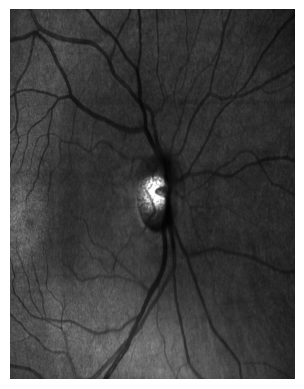

In [15]:
import numpy as np
import matplotlib.pyplot as plt

pixels = np.array(final_df.at[4, 'slo_fundus'])

# According to the dataset docs each SLO photo is 512 × 664 pixels
img = pixels.reshape(664, 512)

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()


In [13]:
final_df.columns

Index(['slo_fundus', 'maritalstatus', 'ethnicity', 'language', 'gender',
       'race', 'age', 'glaucoma'],
      dtype='object')

In [1]:
from utils import count_llama_tokens

/home/yl3427/miniconda3/envs/vllm_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
count_llama_tokens(final_df.at[2, 'slo_fundus'])

85

In [10]:
from textwrap import dedent

system_prompt = dedent("""
    You are an ophthalmology assistant.

    **Task**
    • Judge whether the eye shows glaucomatous damage from the given features.

    **Think**
    • You may reason step‑by‑step internally.
    • Do NOT reveal any hidden scratch work.

    **Output**
    Return **exactly three lines** in the order below—no extra text, no JSON.

    1. Rationale: <≤ 30‑word explanation>
    2. Prediction: <Glaucoma | Non‑Glaucoma>
    3. Confidence: <float between 0 and 1>

    Example:
    Rationale: Older patient with deep cup and nerve‑fiber loss.
    Prediction: Glaucoma
    Confidence: 0.83
""").strip()
print(system_prompt)

You are an ophthalmology assistant.

**Task**
• Judge whether the eye shows glaucomatous damage from the given features.

**Think**
• You may reason step‑by‑step internally.
• Do NOT reveal any hidden scratch work.

**Output**
Return **exactly three lines** in the order below—no extra text, no JSON.

1. Rationale: <≤ 30‑word explanation>
2. Prediction: <Glaucoma | Non‑Glaucoma>
3. Confidence: <float between 0 and 1>

Example:
Rationale: Older patient with deep cup and nerve‑fiber loss.
Prediction: Glaucoma
Confidence: 0.83


# Resulting Data

In [45]:
mimic_df = pd.read_csv('/home/yl3427/cylab/Fairness/mimic_df.csv')

In [46]:
mimic_df[(mimic_df['90_DAY_READMISSION']==1) & (mimic_df['1_YEAR_MORTALITY']==0)].head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,...,DOD,EXPIRE_FLAG,AGE_AT_ADMISSION,CHARTDATE,CHARTTIME,CATEGORY,DESCRIPTION,TEXT,90_DAY_READMISSION,1_YEAR_MORTALITY
1586,10071,150259,2113-11-28 12:00:00,2113-12-11 14:45:00,NaN,ELECTIVE,NaN,OTHER,MARRIED,BLACK/AFRICAN AMERICAN,...,NaN,0,36,2113-11-28,2113-11-28 13:05:00,Radiology,CHEST (PORTABLE AP),[**2113-11-28**] 1:05 PM\n CHEST (PORTABLE AP)...,1,0
1587,10071,150259,2113-11-28 12:00:00,2113-12-11 14:45:00,NaN,ELECTIVE,NaN,OTHER,MARRIED,BLACK/AFRICAN AMERICAN,...,NaN,0,36,2113-11-28,2113-11-28 17:18:00,Nursing/other,Report,PT[**Last Name (STitle) 10111**] MALE S/P AVR/...,1,0
1588,10071,150259,2113-11-28 12:00:00,2113-12-11 14:45:00,NaN,ELECTIVE,NaN,OTHER,MARRIED,BLACK/AFRICAN AMERICAN,...,NaN,0,36,2113-11-28,2113-11-28 17:55:00,Nursing/other,Report,ADDENDUM: PT [**Name (NI) 865**] 1730 TO RA WI...,1,0
1589,10071,150259,2113-11-28 12:00:00,2113-12-11 14:45:00,NaN,ELECTIVE,NaN,OTHER,MARRIED,BLACK/AFRICAN AMERICAN,...,NaN,0,36,2113-11-28,NaN,ECG,Report,Sinus rhythm\nBorderline right axis deviation ...,1,0
1590,10071,150259,2113-11-28 12:00:00,2113-12-11 14:45:00,NaN,ELECTIVE,NaN,OTHER,MARRIED,BLACK/AFRICAN AMERICAN,...,NaN,0,36,2113-11-29,2113-11-29 04:21:00,Nursing/other,Report,"7p-7a:\nneuro: a/ox3, anxious at times. need...",1,0


In [47]:
mimic_df[(mimic_df['90_DAY_READMISSION']==1) & (mimic_df['1_YEAR_MORTALITY']==1)].head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,...,DOD,EXPIRE_FLAG,AGE_AT_ADMISSION,CHARTDATE,CHARTTIME,CATEGORY,DESCRIPTION,TEXT,90_DAY_READMISSION,1_YEAR_MORTALITY
488,1004,127794,2108-05-10 08:00:00,2108-05-25 16:00:00,NaN,ELECTIVE,NaN,UNOBTAINABLE,MARRIED,WHITE,...,2108-06-09,1,55,2108-05-10,2108-05-10 14:12:00,Radiology,TRANSCATH THERAPY,[**2108-5-10**] 2:12 PM\n CAROT/CEREB [**Hospi...,1,1
489,1004,127794,2108-05-10 08:00:00,2108-05-25 16:00:00,NaN,ELECTIVE,NaN,UNOBTAINABLE,MARRIED,WHITE,...,2108-06-09,1,55,2108-05-10,2108-05-10 15:52:00,Radiology,CT HEAD W/O CONTRAST,[**2108-5-10**] 3:52 PM\n CT HEAD W/O CONTRAST...,1,1
490,1004,127794,2108-05-10 08:00:00,2108-05-25 16:00:00,NaN,ELECTIVE,NaN,UNOBTAINABLE,MARRIED,WHITE,...,2108-06-09,1,55,2108-05-10,2108-05-10 17:59:00,Radiology,CHEST (PORTABLE AP),[**2108-5-10**] 5:59 PM\n CHEST (PORTABLE AP) ...,1,1
491,1004,127794,2108-05-10 08:00:00,2108-05-25 16:00:00,NaN,ELECTIVE,NaN,UNOBTAINABLE,MARRIED,WHITE,...,2108-06-09,1,55,2108-05-10,2108-05-10 18:19:00,Nursing/other,Report,Resp Care\nPt remains sedated/intubated on CMV...,1,1
492,1004,127794,2108-05-10 08:00:00,2108-05-25 16:00:00,NaN,ELECTIVE,NaN,UNOBTAINABLE,MARRIED,WHITE,...,2108-06-09,1,55,2108-05-10,2108-05-10 19:29:00,Nursing/other,Report,ADMISSION NOTE / CONDITION UPDATE:\nD/A: PT [*...,1,1


In [36]:
mimic_df[(mimic_df['90_DAY_READMISSION']==0) & (mimic_df['1_YEAR_MORTALITY']==1)].head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,...,DOD,EXPIRE_FLAG,AGE_AT_ADMISSION,CHARTDATE,CHARTTIME,CATEGORY,DESCRIPTION,TEXT,90_DAY_READMISSION,1_YEAR_MORTALITY
113,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NaN,EMERGENCY,NaN,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,...,2165-08-12,1,70,2164-10-23,2164-10-23 20:48:00,Radiology,CHEST (PA & LAT),[**2164-10-23**] 8:48 PM\n CHEST (PA & LAT) ...,0,1
114,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NaN,EMERGENCY,NaN,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,...,2165-08-12,1,70,2164-10-23,2164-10-23 22:01:00,Nursing/other,Report,FULL CODE Universal Precautions\nAlle...,0,1
115,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NaN,EMERGENCY,NaN,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,...,2165-08-12,1,70,2164-10-23,NaN,ECG,Report,Sinus tachycardia. Since the previous tracing ...,0,1
116,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NaN,EMERGENCY,NaN,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,...,2165-08-12,1,70,2164-10-24,2164-10-24 01:13:00,Nursing/other,Report,FULL CODE Universal Precautions Allerg...,0,1
117,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NaN,EMERGENCY,NaN,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,...,2165-08-12,1,70,2164-10-24,2164-10-24 17:19:00,Nursing/other,Report,7a-7p\nsee nursing transfer note\n,0,1


In [48]:
mimic_df[mimic_df["SUBJECT_ID"]==10006]

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,...,DOD,EXPIRE_FLAG,AGE_AT_ADMISSION,CHARTDATE,CHARTTIME,CATEGORY,DESCRIPTION,TEXT,90_DAY_READMISSION,1_YEAR_MORTALITY
113,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NaN,EMERGENCY,NaN,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,...,2165-08-12,1,70,2164-10-23,2164-10-23 20:48:00,Radiology,CHEST (PA & LAT),[**2164-10-23**] 8:48 PM\n CHEST (PA & LAT) ...,0,1
114,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NaN,EMERGENCY,NaN,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,...,2165-08-12,1,70,2164-10-23,2164-10-23 22:01:00,Nursing/other,Report,FULL CODE Universal Precautions\nAlle...,0,1
115,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NaN,EMERGENCY,NaN,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,...,2165-08-12,1,70,2164-10-23,NaN,ECG,Report,Sinus tachycardia. Since the previous tracing ...,0,1
116,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NaN,EMERGENCY,NaN,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,...,2165-08-12,1,70,2164-10-24,2164-10-24 01:13:00,Nursing/other,Report,FULL CODE Universal Precautions Allerg...,0,1
117,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NaN,EMERGENCY,NaN,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,...,2165-08-12,1,70,2164-10-24,2164-10-24 17:19:00,Nursing/other,Report,7a-7p\nsee nursing transfer note\n,0,1
118,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NaN,EMERGENCY,NaN,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,...,2165-08-12,1,70,2164-10-25,2164-10-25 07:16:00,Nursing/other,Report,NPN 1900-0700\nPt awaiting transfer to floor w...,0,1
119,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NaN,EMERGENCY,NaN,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,...,2165-08-12,1,70,2164-10-26,2164-10-26 14:10:00,Radiology,CT ABDOMEN W/CONTRAST,[**2164-10-26**] 2:10 PM\n CT ABDOMEN W/CONTRA...,0,1
120,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NaN,EMERGENCY,NaN,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,...,2165-08-12,1,70,2164-10-26,2164-10-26 14:37:00,Radiology,PICC W/O PORT,[**2164-10-26**] 2:37 PM\n PICC LINE PLACMENT ...,0,1
121,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NaN,EMERGENCY,NaN,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,...,2165-08-12,1,70,2164-10-26,2164-10-26 15:04:00,Radiology,VEN DUP EXTEXT BIL (MAP/DVT),[**2164-10-26**] 3:04 PM\n [**Last Name (un) *...,0,1
122,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NaN,EMERGENCY,NaN,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,...,2165-08-12,1,70,2164-10-27,2164-10-27 12:31:00,Radiology,CT PERITINEAL DRAIN EXCLUDING APPENDICEAL,[**2164-10-27**] 12:31 PM\n CT PERITINEAL DRAI...,0,1


In [49]:
admission_df = pd.read_csv('/secure/shared_data/SOAP/MIMIC/ADMISSIONS.csv')
admission_df[admission_df["SUBJECT_ID"]==10006]

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
11600,12258,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,2164-10-23 16:43:00,2164-10-23 23:00:00,SEPSIS,0,1


In [50]:
patient_df = pd.read_csv('/secure/shared_data/SOAP/MIMIC/PATIENTS.csv')
patient_df[patient_df["SUBJECT_ID"]==10006]

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
9863,9467,10006,F,2094-03-05 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00,2165-08-12 00:00:00,1


In [51]:
for i, row in note_df[note_df["SUBJECT_ID"]=='10006'].iterrows():
    print(row['TEXT'])
    print("==="*20)

Admission Date:  [**2164-10-23**]              Discharge Date:   [**2164-11-1**]

Date of Birth:  [**2094-3-5**]             Sex:   F

Service: MEDICINE

Allergies:
Lidocaine / Heparin Sodium

Attending:[**First Name3 (LF) 18141**]
Chief Complaint:
Fever and chills

Major Surgical or Invasive Procedure:
HD tunnel catheter replacement

History of Present Illness:
Ms. [**Known lastname **] is a 70 year old female with ESRD on HD through
tunneled catheter (hx of peritoneal dialysis until VRE
peritonitis and PD catheter removal in [**2164-10-13**]), HTN, DMII,
CAD, Afib, CHF (EF 50%), who presents from [**Location (un) 4265**] Dialsis with
fever, chills for one hour during HD.  Dialysis was completed
and the patient was transferred to [**Hospital1 18**] where she was found to
have a temperature of 103 and HR of 120 with lactate of 4.4.
Ms. [**Known lastname **] received Ceftriaxone 1g IV, Flagyl 500mg IV, and
tylenol (unasyn 3g x1 written for but never signed) in the ED.
She denied any SOB

In [61]:
gc_df = pd.read_csv('/home/yl3427/cylab/Fairness/glaucoma_df.csv')
gc_df.head()

,slo_fundus,maritalstatus,ethnicity,language,gender,race,age,glaucoma
0,[[21 26 29 ... 3 8 7]\n [23 25 32 ... 4 7...,Single,non-Hispanic,English,Male,White,73,Glaucoma
1,[[15 14 11 ... 57 47 46]\n [14 13 12 ... 55 47...,Marriage or Partnered,non-Hispanic,English,Female,White,58,Non-Glaucoma
2,[[23 25 26 ... 30 28 29]\n [27 25 26 ... 29 28...,Marriage or Partnered,non-Hispanic,English,Male,White,29,Non-Glaucoma
3,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,Marriage or Partnered,non-Hispanic,English,Female,White,59,Non-Glaucoma
4,[[53 53 68 ... 29 30 31]\n [52 53 61 ... 30 35...,Single,Hispanic,English,Female,White,50,Non-Glaucoma


In [62]:
print(gc_df.at[0, 'slo_fundus'])

[[21 26 29 ...  3  8  7]
 [23 25 32 ...  4  7  5]
 [20 24 16 ...  9  6  5]
 ...
 [ 2  4  5 ...  5  8  4]
 [ 2  1  3 ...  7  6  7]
 [ 5  2  3 ...  5  8  8]]
